# Creation of Phantoms with nDTomo

## 📝 Introduction

This tutorial demonstrates how to construct synthetic 2D and 3D phantoms using the `nDTomo` package. Phantoms are simulated geometric or physically inspired structures used to test and benchmark image processing algorithms, especially in chemical imaging and tomography.

Rather than working with experimental data, we will generate **fully synthetic phantoms** composed of simple and composite shapes. These allow us to:
- Validate reconstruction pipelines
- Test segmentation or peak fitting algorithms
- Create controlled training data for machine learning models

The notebook includes both:
- **Random geometric phantoms**, using basic shapes such as spheres and cylinders
- **Procedural phantoms**, with known structure and complexity, inspired by established test datasets in imaging science

## 🧪 Background: Why Use Phantoms?

In chemical tomography and hyperspectral imaging, each spatial pixel often contains a full spectrum or diffraction pattern. Creating synthetic data with known ground truth can help:
- Benchmark analysis tools under controlled noise or overlap conditions
- Understand how reconstruction or denoising methods behave with specific types of features
- Generate datasets where the true components are known, enabling objective comparisons

This notebook focuses on spatial-spectral phantoms that are compatible with XRD-CT, micro-CT, and other chemical imaging modalities.

## 🧰 What This Notebook Covers

We will explore three main phantom creation routes:
1. **Simple 2D shape composition** — build a phantom from basic objects placed on a 2D grid
2. **3D volume population** — simulate spatially distributed solid shapes within a 3D domain
3. **Procedural phantoms** — generate 2D and 3D patterns with known internal structure using `nDTomophantom_2D` and `nDTomophantom_3D`

At each step, we will visualize the results using Napari and optionally explore the simulated data using spectral inspection tools.

Let’s begin by creating a basic 2D phantom.

## 🟦 2D Phantom: Basic Shape Composition

We begin by importing the necessary libraries and enabling compatibility for environments with conflicting OpenMP runtimes (especially relevant on Windows or when using libraries like NumPy, SciPy, and Napari together).

The key tools loaded here include:
- Standard numerical and plotting libraries (`numpy`, `matplotlib`)
- The `napari` viewer for interactive visualisation
- Progress tracking with `tqdm`
- A suite of 2D shape functions from `nDTomo.sim.shapes2D`, including:
  - Basic primitives like circles, rectangles, and ellipses
  - More complex structures like stars, triangles, and Voronoi regions

These shapes will be used to construct synthetic 2D images for testing imaging pipelines.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
import napari
from tqdm import tqdm
from nDTomo.sim.shapes2D import create_circle, create_rectangle, create_triangle, create_equilateral_triangle, create_ellipse, create_star, create_voronoi

## 🖋️ Drawing Individual 2D Shapes

We now create a blank 2D image canvas of size 256×256 pixels, represented as a NumPy array filled with zeros. Onto this canvas, we draw a variety of synthetic shapes using the functions imported from `nDTomo.sim.shapes2D`.

Each shape is added using its own parameters:

- `create_circle`: a circle at position `(50, 50)` with radius 20 and an outline of thickness 4.
- `create_rectangle`: a filled rectangle starting at corner `(50, 50)` with width 10 and height 30.
- `create_equilateral_triangle`: a triangle of side length 50 located around `(100, 100)` with a random orientation.
- `create_ellipse`: an ellipse centered at `(100, 100)` with radii 20 and 10.
- `create_star`: a 7-pointed star at the same location, defined by outer and inner radii.

Each shape is assigned a specific `fill_value` to distinguish it from the background. After drawing, the result is visualised using `matplotlib` to confirm the generated pattern.

> 🔍 Note: Each shape call overwrites the canvas, so only the **last one (`create_star`) is visible**. In practice, these should be drawn on separate copies or composed additively.

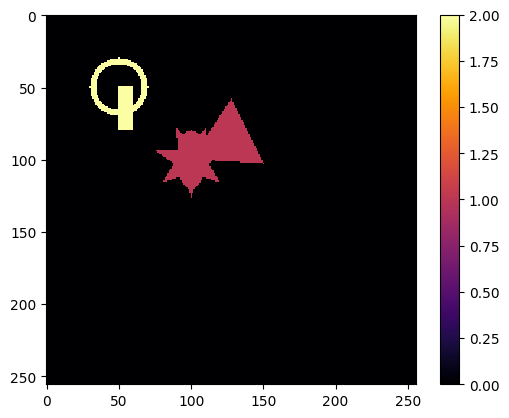

In [2]:
im = np.zeros((256, 256), dtype='float32')
imn = create_circle(im, center=(50,50), radius=20, fill_value=2, thickness=4)
imn = create_rectangle(im, corner=(50,50), width=10, height=30, fill_value=2)
imn = create_equilateral_triangle(im, p1=(100,100), side=50, fill_value=1, orientation='random')
imn = create_ellipse(im, center=(100,100), axes_radii=(20, 10), fill_value=1)
imn = create_star(im, center=(100,100), n_points=7, r_outer=26, r_inner=12, 
                  fill_value=1, angle_offset=0.0)


plt.figure(1);plt.clf()
plt.imshow(imn, cmap='inferno', interpolation='None')
plt.colorbar()
plt.show()

Now we can create a phantom containing a lot of shapes!

100%|██████████| 50/50 [00:00<00:00, 735.04it/s]


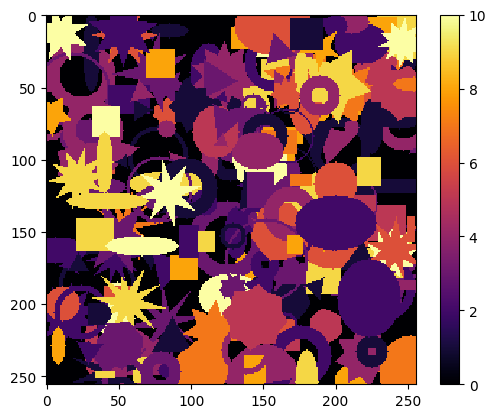

In [6]:
im = np.zeros((256, 256), dtype='float32')
nshapes = 50

for ii in tqdm(range(nshapes)):
    imn = create_circle(im, center=(np.random.randint(0, 256), np.random.randint(0, 256)), 
                        radius=np.random.randint(5, 30), fill_value=np.random.randint(1, 5), 
                        thickness=np.random.randint(1, 11))
    
    imn = create_rectangle(im, corner=(np.random.randint(0, 256), np.random.randint(0, 256)), 
                          width=np.random.randint(5, 30), height=np.random.randint(5, 30), 
                          fill_value=np.random.randint(1, 11))
    
    imn = create_equilateral_triangle(im, p1=(np.random.randint(0, 256), np.random.randint(0, 256)),
                                        side=np.random.randint(5, 30),
                                        fill_value=np.random.randint(1, 5),
                                        orientation='random')
    imn = create_ellipse(im, center=(np.random.randint(0, 256), np.random.randint(0, 256)),
                         axes_radii=(np.random.randint(5, 30), np.random.randint(5, 30)),
                         fill_value=np.random.randint(1, 11))
    imn = create_star(im, center=(np.random.randint(0, 256), np.random.randint(0, 256)),
                      n_points=np.random.randint(5, 11),
                        r_outer=np.random.randint(10, 30), r_inner=np.random.randint(5, 20),
                        fill_value=np.random.randint(1, 11),
                        angle_offset=np.random.uniform(0, 2*np.pi))

plt.figure(1);plt.clf()
plt.imshow(imn, cmap='inferno', interpolation='None')
plt.colorbar()
plt.show()

## 🧩 2D Voronoi Phantom

In this section, we generate a synthetic phantom using a **Voronoi tessellation**, a method commonly used to partition space based on proximity to a set of seed points. This can simulate grain-like or domain-based structures found in many materials and biological systems.

Here's how it works:

- A blank 256×256 pixel canvas is created.
- `num_points = 30` random seed locations are generated across the image domain.
- The `create_voronoi` function from `nDTomo` partitions the image so that each pixel is assigned to the region of the nearest seed point.

The result is a labeled image where each region corresponds to a Voronoi cell. This approach mimics polycrystalline microstructures and is useful for testing segmentation and labeling algorithms.

We visualise the output using a grayscale colormap with a colorbar to indicate region indices.

> ℹ️ Tip: You can increase the number of seeds or vary their positions to simulate more or less granular structures.

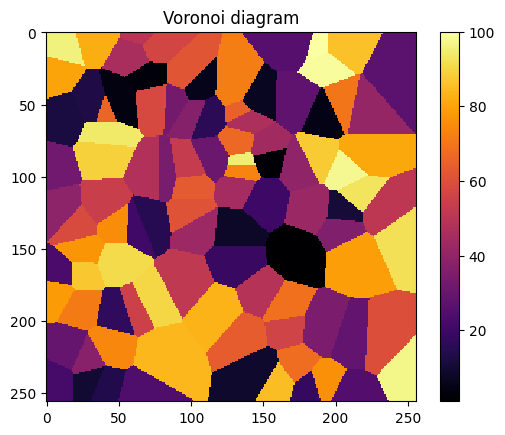

In [4]:
# Define random seed points
size = (256, 256)
num_points = 100
seed_points = [(np.random.randint(0, size[0]), np.random.randint(0, size[1])) for _ in range(num_points)]

# Generate Voronoi diagram
img = np.zeros(size, dtype=int)
imn = create_voronoi(img, seed_points)

plt.figure(1);plt.clf()
plt.imshow(imn, cmap='inferno', interpolation='None')
plt.colorbar()
plt.title('Voronoi diagram')
plt.show()

## 🧱 Importing 3D Shape Primitives

To move into volumetric phantom creation, we now import a comprehensive set of 3D shape generators from `nDTomo.sim.shapes3D`. These functions allow us to simulate a wide variety of geometric objects that can be embedded within a 3D volume.

The available primitives include:

- **Basic solids**: `create_sphere`, `create_cube`, `create_cuboid`, `create_cylinder`, `create_cone`, `create_pyramid`
- **Curved and compound shapes**: `create_torus`, `create_ellipsoid`, `create_mobius_strip`
- **Special structures**: `create_hexagonal_prism`, `create_menger_sponge` (a fractal)

These shapes form the building blocks for synthetic 3D datasets, useful for testing segmentation, denoising, and tomographic reconstruction algorithms. By combining these primitives in different configurations, we can mimic complex internal structures found in real-world samples.

In [8]:

from nDTomo.sim.shapes3D import (create_sphere, create_cube, create_cuboid, create_cylinder, create_cone, create_pyramid, 
                                 create_torus, create_ellipsoid, create_hexagonal_prism,
                                 create_mobius_strip, create_menger_sponge, create_voronoi_3d)

## 🧊 Initialising a 3D Phantom Volume

We now transition to 3D by creating a volumetric canvas — a 256 × 256 × 256 voxel array — filled initially with zeros. This acts as an empty space in which we can embed various synthetic structures.

In the example shown, we draw a single **solid sphere** using:

```
create_sphere(vol, center=(150,150,100), outer_radius=50, fill_value=1)
```

This places a filled sphere at the specified location in the volume, with a radius of 50 voxels and an intensity value of `1`.

Several additional shape generation commands are provided but currently commented out. These include:

- `create_cylinder`: A vertical cylinder with configurable height, radius, and optional caps
- `create_cone`: A conical shape defined by its tip, height, and base radius
- `create_pyramid`: A square-based pyramid with a defined tip and base size
- `create_torus`: A ring-like structure with major and minor radii, optionally hollow
- `create_ellipsoid`: An elongated sphere with different radii along each axis
- `create_hexagonal_prism`: A prism with a hexagonal cross-section extended along the z-axis
- `create_mobius_strip`: A twisted band requiring a high-resolution point cloud
- `create_menger_sponge`: A fractal cube recursively hollowed to a given depth
- `create_cube`: A solid cube placed at the corner of the volume

Uncommenting any of these lines will add the corresponding shape to the phantom volume. These options demonstrate the versatility of `nDTomo.sim.shapes3D` for generating test structures with diverse geometry, complexity, and spatial positioning — ideal for benchmarking 3D imaging workflows.

In [5]:

# Create a 3D array of zeros
shape = (256, 256, 256)  # (x, y, z)
vol = np.zeros(shape, dtype='float32')

vol = create_sphere(vol, center=(150,150,100), outer_radius=50, thickness=0, fill_value=1)
# vol = create_cylinder(vol, center_xy=(200, 25), z_range = (40, 65), outer_radius=50, 
#                       thickness=0, fill_value=12, caps=False)

# vol = create_cone(vol, tip=(50,50,50), height=75, outer_radius=100, fill_value=3)
# vol = create_pyramid(vol, tip=(0,100,200), height=75, base_size=100, fill_value=4)
# vol = create_torus(vol, center=(100,100,150), major_radius=50, minor_radius=20, fill_value=5, hollow_thickness=5)
# vol = create_ellipsoid(vol, center=(100,100,50), radii=(50, 90, 15), fill_value=6, hollow_thickness=0)
# vol = create_hexagonal_prism(vol, center_xy=(100,100), z_range=(180,240), outer_radius=10, fill_value=7)
# vol = create_mobius_strip(vol, center=(100,100,200), major_radius=100, width=20, num_points=10000, fill_value=8)
# vol = create_menger_sponge(vol, center=(100,100,0), size=100, depth=3, fill_value=8)
# vol = create_cube(vol, center=(250,0,240), size=50, fill_value=9)


## 🖼️ Visualising the 3D Phantom with Napari

To inspect the generated 3D phantom, we launch the `napari` viewer in 3D mode using:

```
viewer = napari.Viewer(ndisplay=3)
```

The 3D volume `vol` is added to the viewer with the following display settings:

- `colormap='jet'`: Applies a color gradient to highlight intensity variations
- `blending='additive'`: Allows overlapping objects to be rendered with transparency
- `opacity=0.6`: Makes structures semi-transparent to help visualise internal features

This configuration enables intuitive inspection of the spatial arrangement and overlap of shapes in the phantom.

To capture the rendered view as an image, we use:

```
napari.utils.nbscreenshot(viewer)
```

This is useful for documenting the synthetic dataset or including static visualisations in reports or publications. If working outside a notebook context, consider replacing this with `napari.run()` to keep the viewer open in a standalone window.

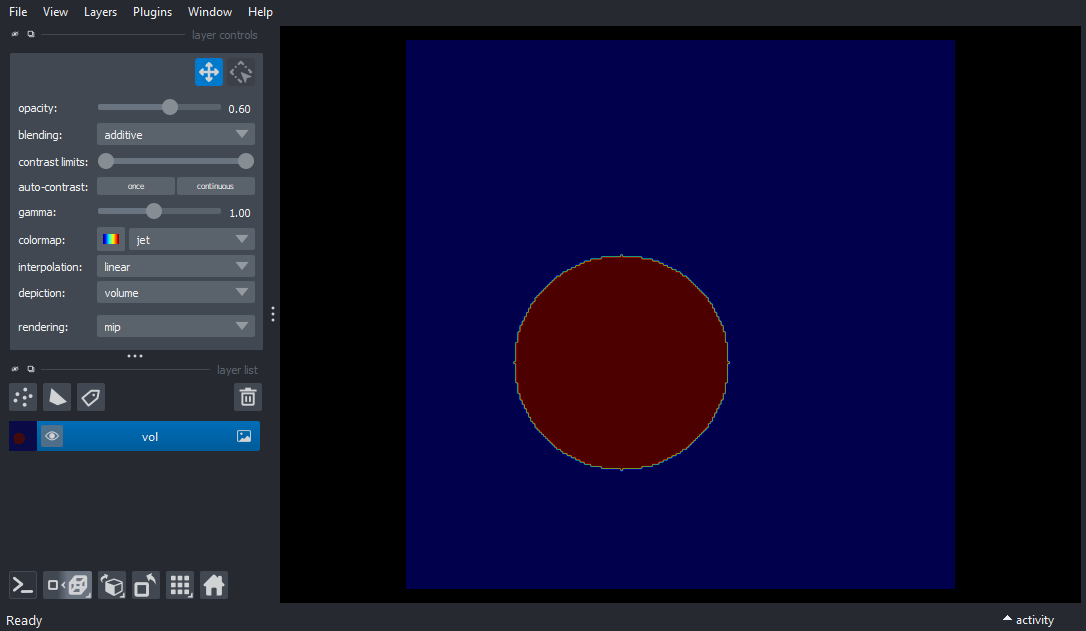

In [6]:
# Start Napari in Jupyter widget mode
viewer = napari.Viewer(ndisplay=3)  # 3D mode
viewer.add_image(vol, colormap='jet', blending='additive', opacity=0.6)

napari.utils.nbscreenshot(viewer)

## 🔁 Populating a 3D Phantom with Randomised Shapes

In this section, we create a synthetic 3D volume populated with multiple randomly positioned and randomly valued shapes. This simulates a heterogeneous sample composed of different materials or phases, as might be encountered in real-world chemical tomography datasets.

We define the volume size as **128 × 128 × 128 voxels** and use the following setup:

- `nshapes = 15`: Number of iterations (each adding three shapes)
- `ofs = 10`: Padding to avoid placing shapes at the edges

In each iteration of the loop, the following occurs:

1. A **pyramid** is placed at a random `(x, y, z)` coordinate with fixed size and a random `fill_value`.
2. A **sphere** is added similarly, with a radius of 20 and a new random value.
3. A **cube** is placed using another randomly sampled location and value.

This process results in a densely packed phantom made up of 45 randomly distributed shapes (15 of each type), with varied intensities to mimic differences in composition or contrast.

Using randomly varying `fill_value`s allows this synthetic phantom to be used for testing quantitative segmentation, clustering, or intensity-based thresholding approaches.

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


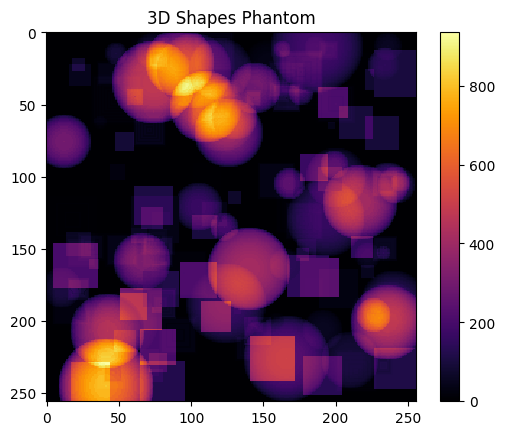

In [9]:
nshapes = 50
ofs = 10
shape = (256, 256, 256)  # (x, y, z)

vol = np.zeros(shape, dtype='float32')

for ii in tqdm(range(nshapes)):

    xi = np.random.randint(0 + ofs, shape[0] - ofs)
    yi = np.random.randint(0 + ofs, shape[1] - ofs)
    zi = np.random.randint(0 + ofs, shape[2] - ofs)
    val = np.random.randint(1, 11)

    vol = create_pyramid(vol, tip=(xi,yi,zi), height=int(10 + 50*np.random.rand(1)[0]), 
                         base_size=int(10 + 25*np.random.rand(1)[0]), fill_value=val)

    xi = np.random.randint(0 + ofs, shape[0] - ofs)
    yi = np.random.randint(0 + ofs, shape[1] - ofs)
    zi = np.random.randint(0 + ofs, shape[2] - ofs)
    val = np.random.randint(1, 11)

    vol = create_sphere(vol, center=(xi,yi,zi), outer_radius=int(5 + 30*np.random.rand(1)[0]), fill_value=val)

    xi = np.random.randint(0 + ofs, shape[0] - ofs)
    yi = np.random.randint(0 + ofs, shape[1] - ofs)
    zi = np.random.randint(0 + ofs, shape[2] - ofs)
    val = np.random.randint(1, 11)

    vol = create_cube(vol, center=(xi,yi,zi), size=int(5 + 30*np.random.rand(1)[0]), fill_value=val)
    

plt.figure(1);plt.clf()
plt.imshow(np.sum(vol, axis=2), cmap='inferno', interpolation='None')
plt.colorbar()
plt.title('3D Shapes Phantom')
plt.show()


## 🔍 Visualising the Randomised 3D Phantom

After populating the volume with randomly distributed pyramids, spheres, and cubes, we use `napari` to inspect the final 3D phantom.

The viewer is launched in 3D mode with:

```
viewer = napari.Viewer(ndisplay=3)
```

The volume is then displayed using the `jet` colormap to emphasise differences in the randomly assigned intensity values (`fill_value`). We also enable:

- `blending='additive'` to allow overlapping shapes to blend visually
- `opacity=0.6` to make the structures semi-transparent, revealing their spatial distribution

Finally, we capture a screenshot of the rendered view with:

```
napari.utils.nbscreenshot(viewer)
```

This step is useful for validating the output visually or for including representative views in documentation or reports.

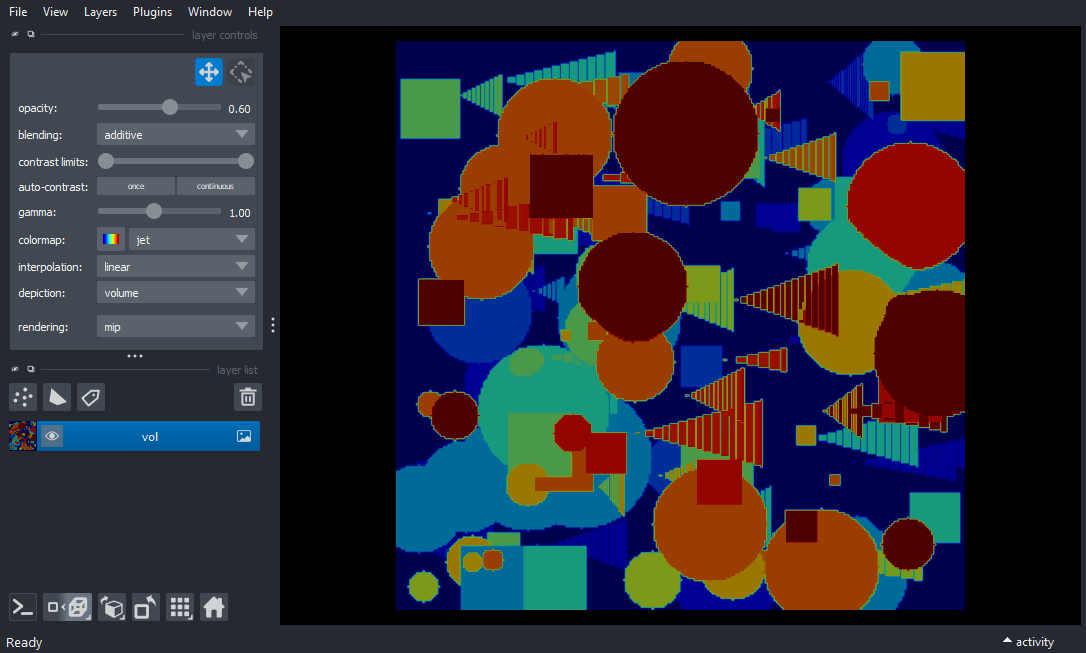

In [14]:
# Start Napari in Jupyter widget mode
viewer = napari.Viewer(ndisplay=3)  # 3D mode
viewer.add_image(vol, colormap='jet', blending='additive', opacity=0.6)

napari.utils.nbscreenshot(viewer)

We can also create a Voronoi 3D and visualise it

250it [02:19,  1.79it/s]


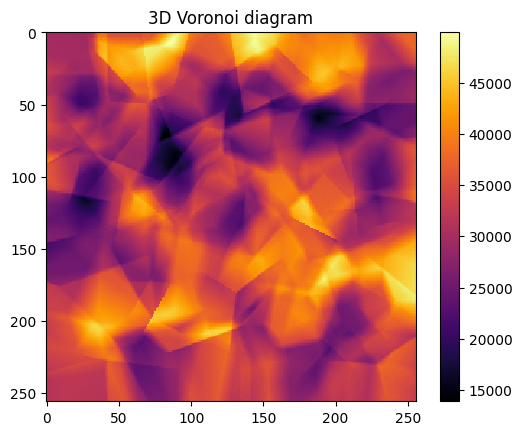

In [ ]:

# Define random seed points
size = (256, 256, 256)
num_points = 250
seed_points = [(np.random.randint(0, size[0]), np.random.randint(0, size[1]), np.random.randint(0, size[2])) for _ in range(num_points)]

# Generate Voronoi diagram
volv = np.zeros(size, dtype='float32')
volv = create_voronoi_3d(volv, seed_points, fill_values=None)

plt.figure(1);plt.clf()
plt.imshow(np.sum(volv, axis=2), cmap='inferno', interpolation='None')
plt.colorbar()
plt.title('3D Voronoi diagram')
plt.show()



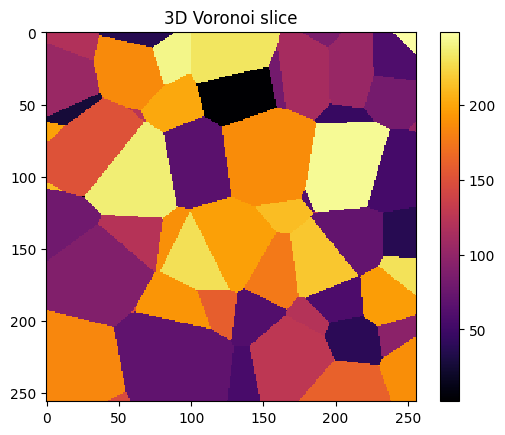

In [19]:
plt.figure(1);plt.clf()
plt.imshow(volv[:,:,int(volv.shape[2]/2)], cmap='inferno', interpolation='None')
plt.colorbar()
plt.title('3D Voronoi slice')
plt.show()


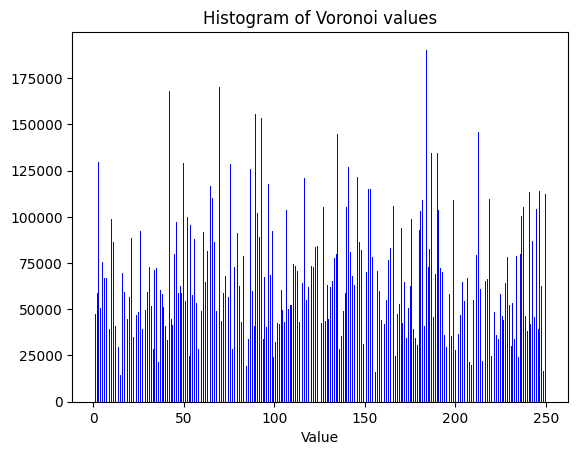

In [21]:
v = volv.flatten()

plt.figure(1);plt.clf()
plt.hist(v, bins=500, color='blue')
plt.title('Histogram of Voronoi values')
plt.xlabel('Value')
plt.show()


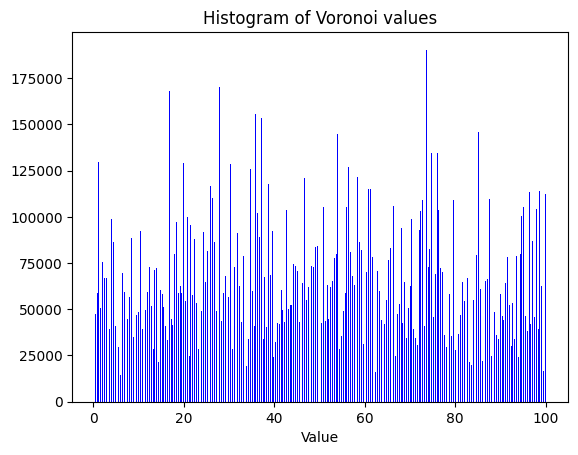

In [22]:
volv = np.float32(volv)
volv = 100*(volv/np.max(volv))
v = volv.flatten()

plt.figure(1);plt.clf()
plt.hist(v, bins=500, color='blue')
plt.title('Histogram of Voronoi values')
plt.xlabel('Value')
plt.show()

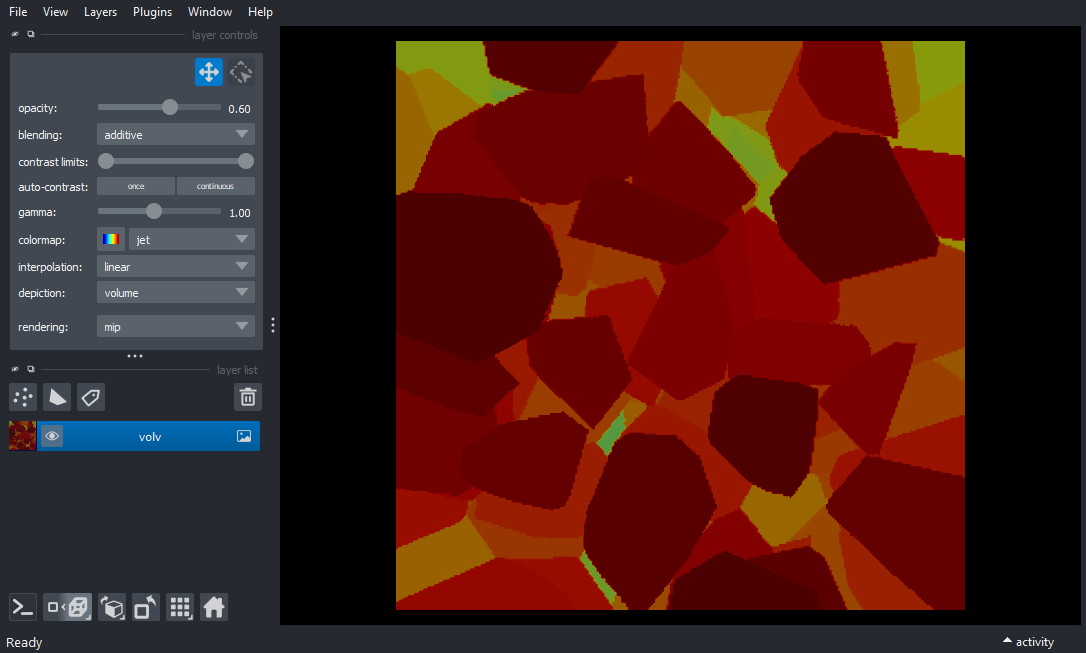

In [23]:
# Start Napari in Jupyter widget mode
viewer = napari.Viewer(ndisplay=3)  # 3D mode
viewer.add_image(volv, colormap='jet', blending='additive', opacity=0.6)

napari.utils.nbscreenshot(viewer)

We can also create a spherical mask and apply it to the 3D volume to get a spherical particle with grains

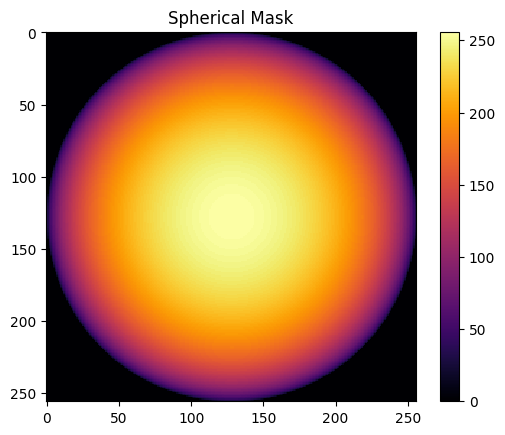

In [24]:
shape = (256, 256, 256)  # (x, y, z)
volm = np.zeros(shape, dtype='float32')
volm = create_sphere(volm, center=(128,128,128), outer_radius=128, thickness=0, fill_value=1)

plt.figure(1);plt.clf()
plt.imshow(np.sum(volm, axis=2), cmap='inferno', interpolation='None')
plt.colorbar()
plt.title('Spherical Mask')
plt.show()


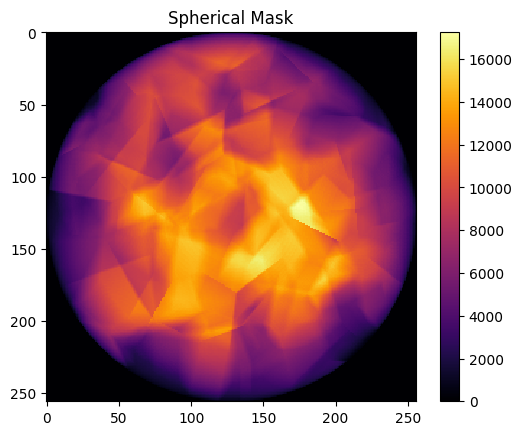

In [25]:
volvm = volm * volv

plt.figure(1);plt.clf()
plt.imshow(np.sum(volvm, axis=2), cmap='inferno', interpolation='None')
plt.colorbar()
plt.title('Spherical Mask')
plt.show()

In [28]:
volm.max()

np.float32(1.0)

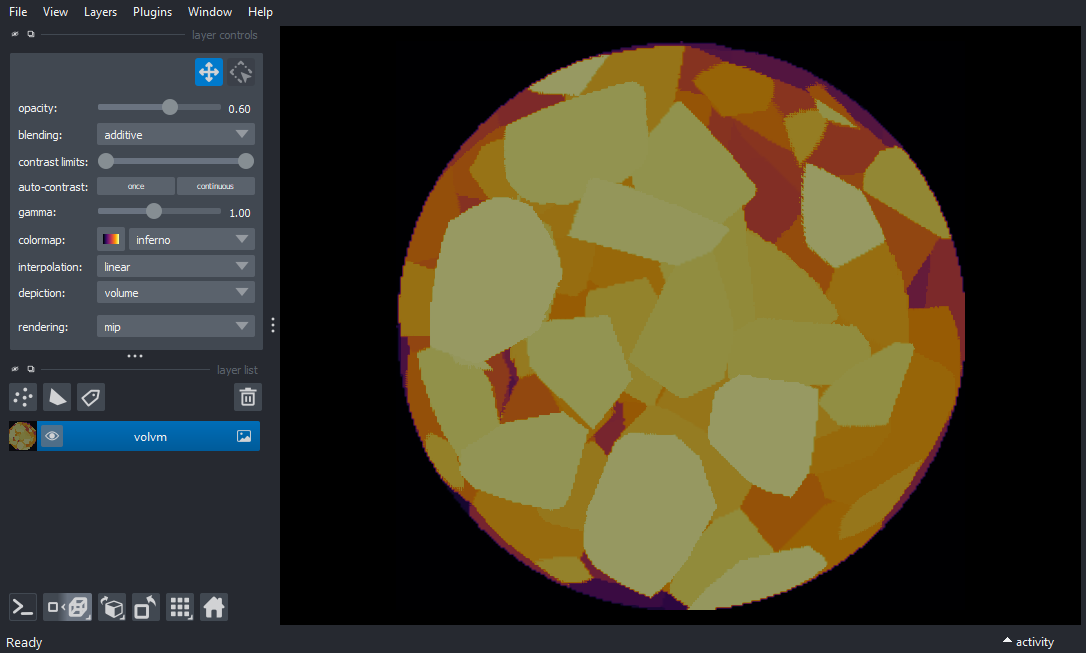

In [29]:
# Start Napari in Jupyter widget mode
viewer = napari.Viewer(ndisplay=3)  # 3D mode
viewer.add_image(volvm, colormap='inferno', blending='additive', opacity=0.6)

napari.utils.nbscreenshot(viewer)

## 🌀 Library-Based 2D Phantoms with `nDTomophantom_2D`

In this section, we move from manually composed shapes to **structured phantom generation** using the `nDTomophantom_2D` function. These phantoms are selected from a predefined library of configurable 2D patterns designed to represent a range of geometric and material-like features.

We begin by importing:

- `nDTomophantom_2D`: the main function for generating test patterns based on a selected ID
- `load_example_patterns`: a utility that lists the available phantom configurations included in the library
- `showim`: a helper function from `nDTomo.methods.plots` for standardised image visualisation

These library-based phantoms are especially useful for benchmarking algorithms, as they provide complex but well-defined structures with known ground truth — enabling objective evaluation of segmentation, clustering, or reconstruction performance.

In [9]:
from nDTomo.sim.phantoms import nDTomophantom_2D, load_example_patterns
from nDTomo.methods.plots import showim

## ⚙️ Generating 2D Component Maps and Reference Patterns

We now use the `nDTomophantom_2D` function to generate five distinct 2D phantoms, each corresponding to a synthetic material component: **Aluminium (Al), Copper (Cu), Iron (Fe), Platinum (Pt), and Zinc (Zn)**. These component maps are designed such that the shapes do not overlap spatially, simplifying interpretation and analysis.

The key steps are:

- `npix = 200`: sets the image resolution to 200 × 200 pixels.
- `nDTomophantom_2D(npix, nim='Multiple')`: generates five non-overlapping binary masks, each representing one synthetic phase. Each output (`imAl`, `imCu`, etc.) is a spatial map where the given component is present.

Next, we load corresponding **reference patterns** using `load_example_patterns()`. These patterns (`dpAl`, `dpCu`, etc.) are representative spectra or diffraction profiles for each component, sampled over the axes `tth` (2-theta) and `q` (scattering vector). These can be used later to simulate hyperspectral or diffraction-based data by projecting them across the spatial maps.

Finally, the five component images are visualised using `showim`, allowing us to inspect their structure and verify that each occupies a distinct region in the domain.

> 🧠 This setup is ideal for testing spatial unmixing or spectral decomposition algorithms under controlled conditions, where the true component locations and reference signals are known.

c:\Users\Antony\.conda\envs\ndtomo\Lib\site-packages\xdesign\geometry\area.py:789: UserWarning: Didn't check that Mesh contains Circle.
  warnings.warn("Didn't check that Mesh contains Circle.")


<KeysViewHDF5 ['Al', 'Cu', 'Fe', 'Pt', 'Zn', 'q', 'tth']>


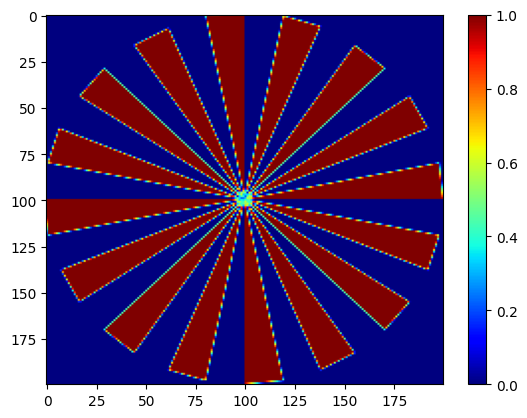

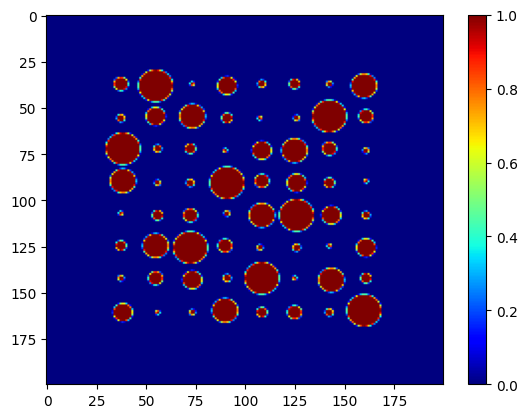

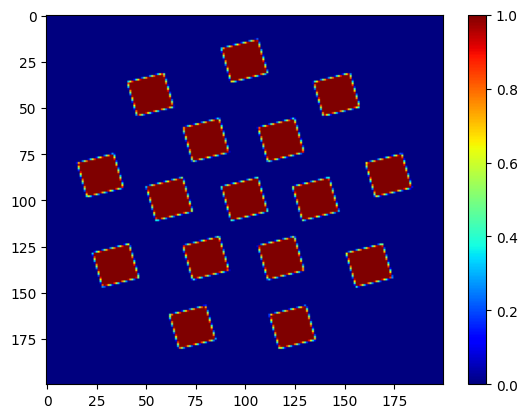

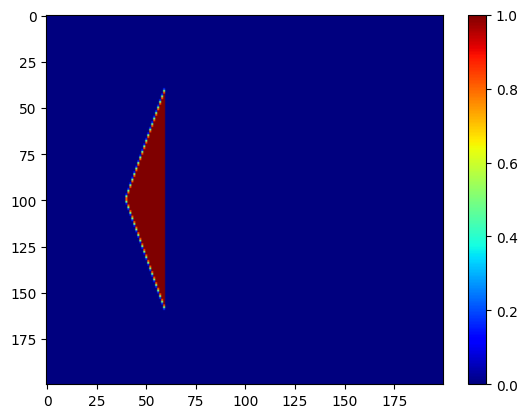

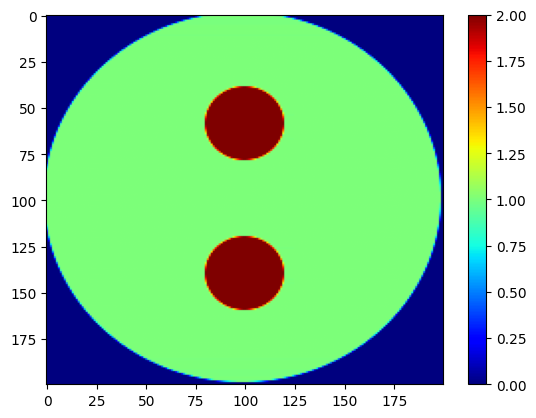

In [10]:
# Image size
npix = 200

# Create 5 distinct phantom images (with non-overlapping shapes)
imAl, imCu, imFe, imPt, imZn = nDTomophantom_2D(npix, nim='Multiple')
iml = [imAl, imCu, imFe, imPt, imZn]

# Load synthetic example patterns and associated axes
dpAl, dpCu, dpFe, dpPt, dpZn, tth, q = load_example_patterns()
spectra = [dpAl, dpCu, dpFe, dpPt, dpZn]

showim(imAl, 2)
showim(imCu, 3)
showim(imFe, 4)
showim(imPt, 5)
showim(imZn, 6)


## 🧩 Constructing a 2D Chemical Phantom with Spectral Signatures

We now construct a synthetic 2D chemical imaging dataset using the `nDTomophantom_3D` function. This function combines spatial component masks (from `nDTomophantom_2D`) with corresponding spectral patterns to generate a **2D + spectral** volume, suitable for simulating hyperspectral or XRD-CT datasets.

The function call used here is:

```
chemct = nDTomophantom_3D(
    npix,
    use_spectra='Yes',
    spectra=spectra,
    imgs=iml,
    indices='All',
    norm='No'
)
```

### 🔧 Key Parameters:
- `npix`: sets the spatial resolution (200 × 200 pixels).
- `use_spectra='Yes'`: instructs the function to generate a spectral dataset instead of a volumetric stack.
- `spectra`: a list of 1D spectral patterns (e.g. diffraction intensities) associated with each material/component.
- `imgs`: a list of 2D masks defining where each component is present in the spatial domain.
- `indices='All'`: applies all spectral patterns across their full range of channels.
- `norm='No'`: disables any intensity normalisation to preserve the raw scaling of the spectral data.

### 🧪 What the Function Does:
When `use_spectra=True`, the function creates a 3D volume of shape `(npix, npix, nch)`, where `nch` is the number of spectral channels (determined by the length of each spectrum).

Each spatial mask is multiplied voxel-wise by its corresponding spectrum and then added to the output volume. Because the component images are **non-overlapping**, this results in a clean chemical phantom where each spatial region has a well-defined spectral identity.

This synthetic dataset is ideal for evaluating:
- Spectral unmixing or factorisation algorithms (e.g. NMF, PCA)
- Clustering or classification methods
- Spectral compression or denoising pipelines

The output shape is printed to confirm the dimensions of the simulated chemical volume.

In [11]:
from nDTomo.sim.phantoms import nDTomophantom_3D

chemct = nDTomophantom_3D(npix, use_spectra='Yes', spectra=spectra, imgs=iml, indices='All', norm='No')
print('Simulated chemical volume shape:', chemct.shape)

100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

Simulated chemical volume shape: (200, 200, 250)


## 🧪 Interactive Exploration of the Chemical Volume

To conclude the tutorial, we explore the synthetic chemical volume interactively using the `chemimexplorer` — a lightweight Jupyter-based GUI included in `nDTomo`. This tool provides linked views of the spatial and spectral domains, enabling intuitive inspection of hyperspectral or diffraction-based datasets.

### 🛠️ How it works:
- The `chemimexplorer` widget is launched by passing the simulated volume `chemct` to its constructor.
- The volume must have shape `(x, y, spectral_channels)`, consistent with what we generated using `nDTomophantom_3D`.
- The viewer allows users to click on any pixel and immediately view the associated spectrum.

### 🧭 Features:
- Interactive cursor-based inspection of spectra
- Automatic display of spatial context and spectral profile
- Compatible with any 2D + spectral dataset

Before launching the viewer, we enable interactive plotting in the notebook using:

```
%matplotlib widget
```

This is required for the GUI to render properly inside a Jupyter environment.

Finally, we instantiate the tool:

```
gui = chemimexplorer(chemct)
```

This provides an effective way to validate the simulated phantom, check the spectral assignment, and visually explore the structure of the synthetic chemical dataset.

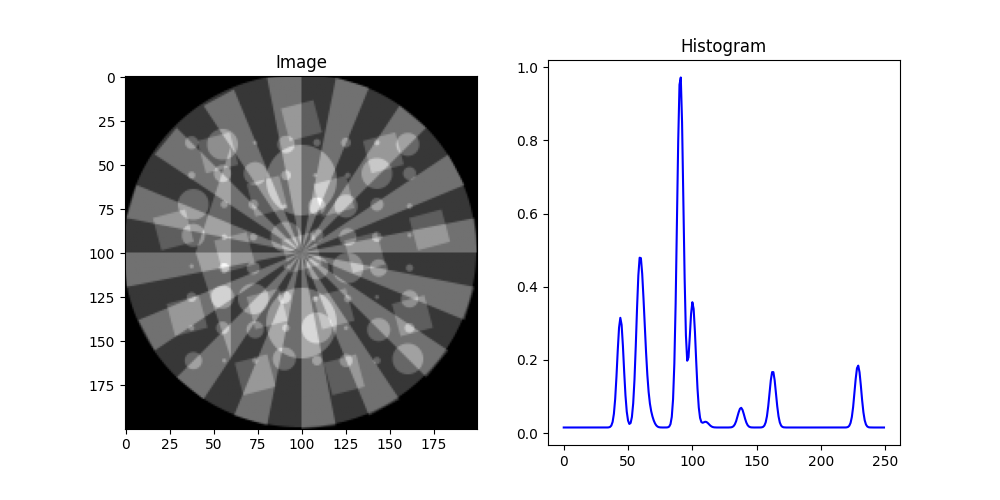

In [12]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(chemct)

## ✅ Summary and Next Steps

In this tutorial, we demonstrated how to generate synthetic 2D and 3D phantoms using the `nDTomo` package — a flexible toolkit for creating spatial-spectral datasets tailored to chemical imaging and diffraction tomography workflows.

We covered three main phantom construction strategies:

1. **Manual 2D and 3D Shape Composition**  
   Using basic geometric primitives (circles, rectangles, spheres, pyramids, etc.) to construct test structures with known shapes and intensities.

2. **Library-Based 2D Phantoms and Spectra**  
   Employing predefined component maps and reference spectra to simulate distinct chemical phases, such as Al, Cu, Fe, Pt, and Zn.

3. **3D Chemical Phantoms with Spectral Embedding**  
   Combining spatial masks and spectral signatures to generate a realistic chemical tomography dataset, where each pixel contains a simulated spectrum.

We also explored how to:
- Visualise both 2D and 3D data using `matplotlib` and `napari`
- Interact with the final dataset using `chemimexplorer` for real-time spectral inspection

These synthetic datasets are invaluable for developing, benchmarking, and validating methods for:
- Reconstruction and denoising
- Spectral decomposition and unmixing
- Clustering and segmentation
- Machine learning model training

> 🧭 **Next steps**: You can extend this workflow by adding noise, simulating detector effects, or mixing spectral components to create more challenging test cases. These tools also pair well with unsupervised learning techniques, as shown in other `nDTomo` tutorials.

We hope this notebook provides a solid foundation for synthetic data generation in your own research!